<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S23_sorter_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import gtsam

from gtbook.discrete import Variables
from gtbook.display import show

from IPython.display import SVG, display
from ipywidgets import interact

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtbook
VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)

In [3]:
# Define variables here
Conductivity = VARIABLES.binary("Conductivity")
Detection = VARIABLES.discrete("Detection", ["bottle", "cardboard", "paper"])
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
Category = VARIABLES.discrete("Category", categories) # Not an accident that it is defined last.

# Sensors for Sorting Trash

> We will model three sensors for our trash sorting system.

In [4]:
from gtbook.display import randomImages
from IPython.core.display import display
display(randomImages(2, 3, "steampunk", 1))

How can our trash sorting system know the category of an object that enters the sorting area? Robots use sensors to measure aspects of the world, and then make inferences about the world state based on these measurements. So, sensing can be used to infer the type of the object.

Let us assume our robot cell only has three sensors:
* a conductivity sensor, outputting true|false
* a camera with a three detection algorithms: bottle, cardboard, paper
* a scale, outputting continuous value in kg.

we will discuss each in turn.

## Binary Sensors

> A binary sensor can be modeled using conditional probability distributions.

Sadly, sensors are imperfect devices. For example, consider a sensor that measures electrical conductivity. Suppose we have a binary sensor that simply returns `True` or `False` , based a measurement from an electrical probe, for an object's conductivity.  For a metal can, this sensor will return `True` almost every time; however, some cans may be a bit dirty, or the probe may not make good contact, and these can lead to a mis-classification, returning `False` .

Probability theory lets us quantify this. For example, for a metal can, the probability of the sensor returning `True` might be $0.9$, and hence the probability of returning `False` is $1-0.9=0.1$. 
Of course in reality, we cannot know the true values of these probabilities, but we can estimate them using statistics: do a bunch of experiments, make a histogram.

Because the probability of the outcome depends on the type of the trash item, we represent this with a **Conditional Probability**, which accords a value 

$$P(conductive| trash~category)$$

to every possible outcome (only `True` or `False` for this example), and where the `|` indicates that this depends on the category of the trash item. For example, we already established that

$$P(conductive=True| trash~category=can)=0.9$$

$$P(conductive=False| trash~category=can)=0.1$$

There are many ways to specify conditional probabilities, but in this simple case -with a binary outcome and a finite number of discrete categories- the simplest representation is to use a a **Conditional Probability Table** or CPT. An example is shown below, using Python code:


### Example {-}
An example is shown below, taking care to first create the variables for pretty-printing:


In [5]:
pCT = gtsam.DiscreteConditional(
    Conductivity, [Category], "99/1 99/1 10/90 15/85 95/5")
pretty(pCT)

Category,false,true
cardboard,0.99,0.01
paper,0.99,0.01
can,0.1,0.9
scrap metal,0.15,0.85
bottle,0.95,0.05


Note the rows add up to 1.0, as each row is a valid probability mass function (PMF).


## Conditional Probabilities

In general, the probability mass function of *any* single variable $X$ can be
parameterized by a parameter $Y$, whose value we assume as known. 
This corresponds to the notion of a conditional probability,
which we write as 

$$P(X|Y=y).$$

Note that given a particular value of
$Y$, this is just a distribution over $X$, with parameters given by a
PMF, as before. But, because $Y$ can take on several values, we now need
a **conditional probability table** or CPT to exhaustively describe our
knowledge.

Conditional probability distributions are a great way to represent
knowledge about the world in robotics. In particular, we use them
to model sensors in this chapter.
In the next chapter, we will use them to model 
how we can affect the state of the robot by *actions*.

A complete **sensor model** specifies a (potentially giant) CPT for every
possible state. An observation $O$ can be rather impoverished, or very
detailed, and one can also envision modeling several different sensors
on the robot. In the latter case, we will be able to *fuse* the
information from multiple sensors.

Conditional probability tables do not *have* to be specified as giant
tables. In case we index the discrete states with semantically
meaningful indices, as in the grid-world example, we can often give the
CPT in parametric form.

## Multi-Valued Sensors

Binary sensors are easily generalized to multi-valued sensors. For our running example, we assume that there is a camera mounted in the work cell, looking down on the trash conveyor belt. The camera is connected to a computer which runs a vision algorithm that can output three possible detected classes: `bottle` , `cardboard` , and `paper` :

$$P(detection| trash~category)$$

 The CPT for this sensor now has three columns, and one plausible CPT is given in python code below:


In [6]:
pDT = gtsam.DiscreteConditional(
    Detection, [Category], "2/88/10 2/20/78 1/1/1 1/1/1 95/2/3")
pretty(pDT)


Category,bottle,cardboard,paper
cardboard,0.02,0.88,0.1
paper,0.02,0.2,0.78
can,0.333333,0.333333,0.333333
scrap metal,0.333333,0.333333,0.333333
bottle,0.95,0.02,0.03


As you can tell, this detector is pretty good at detecting cardboard: $P(D=cardboard|T=cardboard) = 0.88$. Incidentally, this means that it still mis-classifies cardboard about 1 in 10 times, 12% to be exact, as $1-0.88 = .12$. Unfortunately, our "vision sensor" is not great when dealing with classes it does *not* know about, which is rather typical of this type of model. Hence, for a metal can, it basically outputs a class at random.


## Continuous Valued Sensors

Next we discuss continuous-valued sensors, like a *scale*. It stands to reason that the weight of an object is a great indicator of what category it might belong to. However, how do we treat *continuous* measurements? One could do a very fine histogram on some discretized weight scale, so we can use the `DiscreteConditional` machinery from above. However, that feels disingenuous.

Instead, we resort to the omnipresent "Bell curve": let us assume that we can fit a Gaussian curve to the data of a particular category. As a reminder, a Gaussian curve is defined as below:

In [7]:
def Gaussian(x, mu=0.0, sigma=1.0):
    return np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi*sigma**2)

We can easily plot this using plotly:

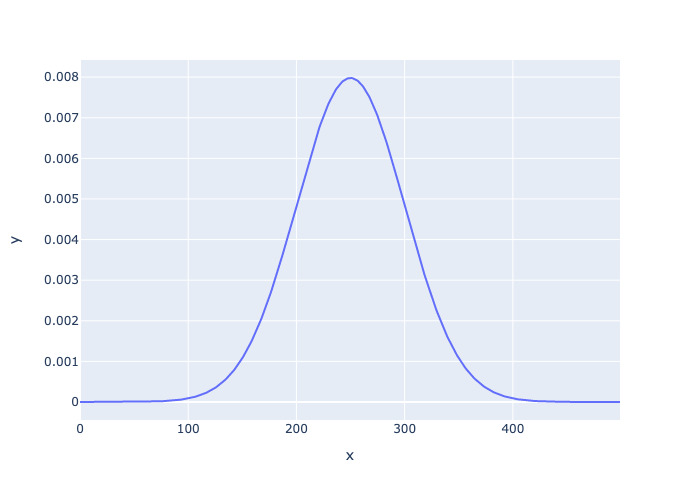

In [8]:
X = np.arange(0, 500)
px.line(x=X, y=Gaussian(X, mu=250, sigma=50))

The area under a Gaussian curve integrates to $1.0$, and hence can use it to model the conditional probability of a continuous quantity. However, for any given continuous value, the probability is zero: we can only use the Gaussian as a *density*, integrating over a small (or large) continuous interval to obtain the probability of the value landing within that interval.

We write a conditional **density** with a lowercase p to indicate it is a density over a continuous quantity. The condition behind the bar is still a discrete category:

$$p(Weight|Category)$$


Let us assume that we fit a Gaussian to the weight of a sample of objects from every one of our 5 categories. We can represent the resulting mean and standard deviation (specified in in grams) any way we want, e.g., as a numpy array as below:

In [9]:
pWC = np.array([[20, 10], [5, 5], [15, 5], [150, 100], [300, 200]])
pWC

array([[ 20,  10],
       [  5,   5],
       [ 15,   5],
       [150, 100],
       [300, 200]])

You might not remember what the 5 categories were, so let's make a small interactive applet wherein we can change the category to see the resulting conditional density:

In [10]:
# Plot conditional density given category T
@interact(Category=categories)
def plot_weight_density(Category="can"):
    index = categories.index(Category)
    display(px.line(x=X, y=Gaussian(X, *pWC[index])))

interactive(children=(Dropdown(description='Category', index=2, options=('cardboard', 'paper', 'can', 'scrap m…

## Simulation by Sampling

> Simulation is sampling from both state and measurement.

We can sample from a conditional distribution $p(X|Y)$ by selecting the
appropriate PMF, depending on the value of $Y$, and proceeding as before
using the inverse transform sampling method.

Hence, to simulate our trash example for a single discrete sensor, we have to sample in two steps. We sample from the category prior $C$ (Section 1.1), and then sample from the conditional $P(S|C)$. Sampling from a conditional works exactly the same way - via the cumulative distribution function. Here we will not belabor that again, but just use the sample method in GTSAM:


In [11]:
category_prior = gtsam.DiscretePrior(Category, "200/300/250/200/50")
pretty(category_prior)

Category,value
cardboard,0.2
paper,0.3
can,0.25
scrap metal,0.2
bottle,0.05


In [12]:
# sample from category
category = category_prior.sample()
print(f"category={category}")

# then sample from the discrete sensors
# TODO: single value
values = gtsam.DiscreteValues()
values[Category[0]] = category
print(f"conductivity = {pCT.sample(values)}")
print(f"detection = {pDT.sample(values)}")

category=0
conductivity = 0
detection = 2


For a continuous sensor, we can use numpy to sample from the continuous density $p(S|C)$:

In [13]:
# sample from Gaussian with `numpy.random.normal`
print(f"weight = {np.random.normal(*pWC[category])}")

weight = 20.994905253150684


## Simulating Multiple Sensors

> To simulate multiple sensors, we sample from the state, and then from all sensors.

Code:

In [14]:
# Sample from state, then from all three sensors:
def sample():
    category = category_prior.sample()
    values = gtsam.DiscreteValues()
    values[Category[0]] = category
    conductivity = pCT.sample(category)
    detection = pDT.sample(category)
    weight = np.random.normal(*pWC[category])
    return category, conductivity, detection, weight

In [15]:
for _ in range(10):
    print(sample())

(1, 0, 1, 1.6034699357780897)
(2, 1, 1, 17.506805744993684)
(2, 1, 2, 23.296719423723353)
(1, 0, 2, 5.915818481881729)
(1, 0, 2, 0.20982640125160756)
(0, 0, 1, 3.4672696568636816)
(1, 0, 1, 2.8623339202650118)
(1, 0, 2, 8.543692524138217)
(3, 1, 0, 225.37323557344516)
(1, 0, 2, 3.6392086429386663)


## What did we learn?

**TODO** Do this automatically?


## GTSAM 101

> The GTSAM concepts used in this section, explained.

Above we created an instance of the `gtsam.DiscreteConditional` class. As with any GTSAM class, you can type

```python
help(gtsam.DiscreteConditional)
```

to get documentation on its constructors and methods. In particular, we called the constructor

```python
 __init__(self: gtsam.gtsam.DiscreteConditional, 
          key: Tuple[int, int], 
          parents: List[Tuple[int, int]], 
          spec: str) -> None
 ```

which expects *three* arguments (besides `self`, which you can ignore):
* `key`: A tuple (id, cardinality), saying which variable this conditional is on.
* `parents`: A *list* of tuples, specifying the variables behind the bar.
* `spec`: A string that specifies a CPT (remember: conditional probability table) which is given as a string of PMF specifications (numbers, separated by `/`), in turn separated by spaces. There should be as many PMFs as there are different assignments to the parent values.

We have not actually used this before, but let's look at an example where there are *two* parents:

In [16]:
conditional = gtsam.DiscreteConditional(Category, [Conductivity, Detection], 
    "6/1/1/1/1 1/6/1/1/1 1/1/6/1/1 1/1/1/6/1 1/1/1/1/6 3/1/2/1/3")
pretty(conditional)

Conductivity,Detection,cardboard,paper,can,scrap metal,bottle
false,bottle,0.6,0.1,0.1,0.1,0.1
false,cardboard,0.1,0.6,0.1,0.1,0.1
false,paper,0.1,0.1,0.6,0.1,0.1
true,bottle,0.1,0.1,0.1,0.6,0.1
true,cardboard,0.1,0.1,0.1,0.1,0.6
true,paper,0.3,0.1,0.2,0.1,0.3


 As you can see above, we had to specify six PMF groups, because there are six combinations of conductivity and detection values. The PMF specifications are read in the order that you see in the table representation above. Since conductivity is mentioned first in the parent list, it varies the slowest. It is important to pay attention to disordering rent specifying conditional probability tables in this way.

We saw in Section 2.1 that GSM represents probability mouse functions as decision trees. It should come as no surprise that GTSAM also represents discrete *conditional* distributions in this way, i.e., as decision trees with more than one level. For example, for the binary conductivity sensor we have:

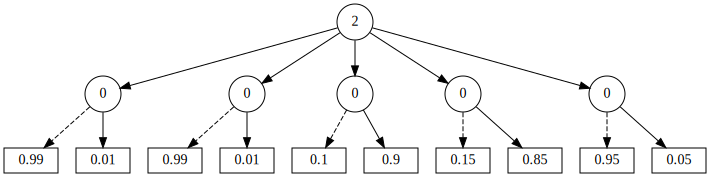

In [17]:
show(pCT)

Now each PMF on the conductivity, given the category, corresponds to a small "decision stump" at the lower level of the tree, where the two leaf probabilities always add up to 1.0.

For the three-valued sensor, we get the following decision tree:


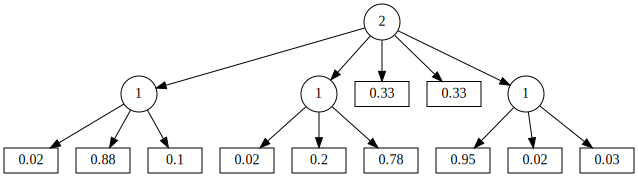

In [18]:
show(pDT)

Again, the decision between the 3 detections is made probabilistically at the stump level, but note a peculiar property of this sensor: for categories `can` and `scrap metal` (category indices 2 and 3, respectively) the probability is exactly $1/3$, *regardless* of the detection, so the stump is simply omitted.